# Analysis

In [71]:
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


kg_data = []
with open ("id2kg_0_100.json") as f:
    for line in f:
        kg_data.append(json.loads(line))


with open("eli5-train-kilt-dpr-kg-hop2.json") as f, open("id2kg_scores_0_100.json", 'w') as fw:
    for i,line in enumerate(f):
        if i == 100:
            break
        obj = json.loads(line)
        answers = [x["answer"] for x in obj["output"] if x["meta"]["score"] >= 3]
        answer_words = []
        for ans in answers:
            words = set()
            for x in ans.split():
                w = lemmatizer.lemmatize(x)
                if w not in stop_words:
                    words.add(w.lower())
            answer_words.append(words)
        # if len(answer_words) == 0:
        #     print(answers)
        # print(answer_words)
        kg_info = kg_data[i]
        assert kg_info["id"] == obj["id"]
        kg_triples = set(kg_info["kg"])
        kg_scores = []
        for triple in kg_triples:
            kg_words = set()
            for part in triple.split('\t'): # object, relation, subject
                kg_words.update([lemmatizer.lemmatize(w).lower() for w in part.split() if lemmatizer.lemmatize(w) not in stop_words])
            counts = []
            precisions = []
            for ans_words in answer_words:
                cnt = len(kg_words & ans_words)
                p = cnt / len(kg_words) if cnt > 0 else 0
                counts.append(cnt)
                precisions.append(p)
            tmp = {"triple":triple, "count": counts, "precision": precisions}
            kg_scores.append(tmp)
        if len(kg_scores[0]["count"]) > 0: # sort by useful triple count
            kg_scores = sorted(kg_scores, key=lambda x: max(x["count"]), reverse=True)
        new_obj = {"id": obj["id"], "kg_scores": kg_scores}
        fw.write(json.dumps(new_obj)+'\n')


[nltk_data] Downloading package wordnet to
[nltk_data]     /afs/crc.nd.edu/user/m/myu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /afs/crc.nd.edu/user/m/myu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


useful rate DescribeResult(nobs=90, minmax=(0.008103727714748784, 0.8533685601056803), mean=0.44406347433836046, variance=0.05551441280712559, skewness=-0.16986727022245718, kurtosis=-1.1656260283670483)
useful count DescribeResult(nobs=90, minmax=(5, 699), mean=271.15555555555557, variance=29497.99800249688, skewness=0.5234024754193711, kurtosis=-0.5208258516238393)


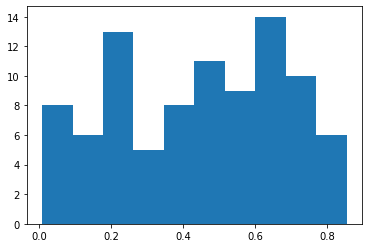

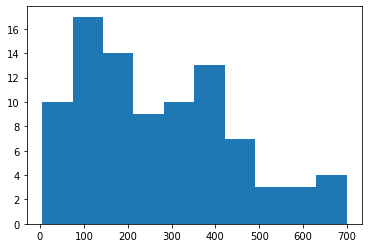

In [72]:
# sort by number of overlapping words with answers
import scipy.stats as stats
useful_rates = []
useful_counts = []
with open ("id2kg_scores_0_100.json") as f:
    for line in f:
        obj = json.loads(line)
        kg_scores = obj["kg_scores"]
        if len(kg_scores[0]["count"]) == 0: # no good answers
            continue
        kg_scores = sorted(kg_scores, key=lambda x: max(x["count"]), reverse=True)
        # print(kg_scores)
        cnt_useful_triple = 0
        for item in kg_scores:
            count = max(item["count"]) if len(item["count"]) > 0 else 0 
            if count > 0:
                cnt_useful_triple += 1
        # print(cnt_useful_triple)
        useful_counts.append(cnt_useful_triple)
        useful_rate = cnt_useful_triple / len(kg_scores)
        useful_rates.append(useful_rate)
print("useful rate", stats.describe(useful_rates))
print("useful count", stats.describe(useful_counts))
import matplotlib.pyplot as plt
plt.hist(useful_rates)
plt.show()

plt.hist(useful_counts)
plt.show()
                
            

In [73]:
with open ("id2kg_scores_0_100.json") as f:
    for i,line in enumerate(f):
        if i == 10:
            break

        obj = json.loads(line)
        kg_scores = obj["kg_scores"]
        if len(kg_scores[0]["count"]) == 0: # no good answers
            continue
        print("id", obj['id'])
        print("Top 10:")
        for x in kg_scores[:10]:
            triple = ", ".join(x["triple"].split('\t'))
            print(max(x["count"]), max(x["precision"]), f"({triple})")
        print("Bottom 10:")
        for x in kg_scores[-10:]:
            triple = ", ".join(x["triple"].split('\t'))
            print(max(x["count"]), max(x["precision"]), f"({triple})")

id 1oy5tc
Top 10:
3 0.6 (offenses, attack, strong pass rush)
3 0.75 (offenses, attack, pass rush)
2 0.2857142857142857 (wide receiver screen play, is intended, to forward pass)
2 0.4 (wide receiver screen play, be, pass)
2 0.4 (Rush Rushing, is, action taken by offense)
2 0.3333333333333333 (wide receiver screen play, is intended, pass)
2 0.2857142857142857 (offense clock management stance, may shift, offense gets)
2 0.25 (wide receiver screen play, is usually intended, forward pass)
2 0.3333333333333333 (wide receiver screen play, be, forward pass)
2 0.25 (offense clock management stance, Finally may shift, as offense gets)
Bottom 10:
0 0 (receiver, can act as, rusher on several kinds)
0 0 (quarterback, is, principally used as part by team)
0 0 (receiver, can act as, rusher)
0 0 (quarterback, is principally used by, team)
0 0 (quarterback, is used by, team)
0 0 (drops, is incomplete, fumble)
0 0 (rushing, is charging across, line of scrimmage towards quarterback)
0 0 (receiver, can ac

# build datasets for classification

In [6]:

import json
import random
random.seed(42)

id2question = {}
with open("eli5-train-kilt-dpr-kg-hop2.json") as f:
    for i,line in enumerate(f):
        if i == 100:
            break
        obj = json.loads(line)
        id2question[obj["id"]] = obj["input"]
 
test_rate = 0.1

all_data = []
with open ("id2kg_scores_0_100.json") as f:
    for i,line in enumerate(f):
        obj = json.loads(line)
        kg_scores = obj["kg_scores"]
        if len(kg_scores[0]["count"]) == 0: # no good answers
            continue       
        all_data.append(obj)
        
list_ids = list(range(len(all_data)))
random.shuffle(list_ids)
test_num = int(test_rate * len(list_ids))
test_ids = list_ids[:test_num]
dev_ids = list_ids[test_num: test_num*2]
test_data = []
dev_data = []
train_data = []
for i, obj in enumerate(all_data):
    for j, kg_info in enumerate(obj["kg_scores"]):
        label = 1 if max(kg_info["count"]) > 0 else 0
        data_item = {
            "id": f"{obj['id']}_j",
            "question": id2question[obj['id']],
            "triple": kg_info["triple"],
            "label": label
        }
        if i in test_ids:
            test_data.append(data_item)
        elif i in dev_ids:
            dev_data.append(data_item)
        else:
            train_data.append(data_item)
print(len(test_ids), len(dev_ids), len(list_ids) - len(test_ids) - len(dev_ids))
print(len(test_data), len(dev_data), len(train_data))

with open("triple_cls/data_train.json", 'w') as f:
    for x in train_data:
        f.write(json.dumps(x) + '\n')
with open("triple_cls/data_dev.json", 'w') as f:
    for x in dev_data:
        f.write(json.dumps(x) + '\n')

with open("triple_cls/data_test.json", 'w') as f:
    for x in test_data:
        f.write(json.dumps(x) + '\n')
            

9 9 72
6914 4554 44453
